<a href="https://colab.research.google.com/github/sotha-sil-zen/MCM/blob/main/midterm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computing the Stationary Distribution

In this question we will consider a Markov chain on the set of all letters, a space, and a period.
We compute the frequencies of letter pairs appearing in a long English book, and decide our transition probabilities based on this (as described below).

Your task is to describe an algorithm that will compute the stationary distribution, and implement it.

In [11]:
%matplotlib inline

import numpy as np, matplotlib as mpl, scipy as sp, scipy.stats as st
from matplotlib import pylab, mlab, pyplot as plt
from matplotlib.pylab import plot, scatter, contour, xlabel, ylabel, title, legend, subplot, fill_between
from matplotlib.animation import FuncAnimation

from numpy import sqrt, pi, exp, log, floor, ceil, sin, cos
from numpy import linspace, logspace, arange, empty, zeros, ones, empty_like, zeros_like, ones_like, full, full_like
from numpy import diff, meshgrid, mean, std, argmin, array, eye, amin, amax, fmin, fmax
from numpy.linalg import norm

import re, multiprocessing as mp, networkx as nx, json
from collections import defaultdict
from tqdm.notebook import tqdm, trange

plt.rcParams.update({
    'image.cmap': 'coolwarm',
    'animation.html': 'jshtml',
    'animation.embed_limit': 40, # 40 mb
})
rng = np.random.default_rng()

```python
# To run this cell change the type back to "code".

# Compute frequencies, and save to file
alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ. '
list_alphabet = list(alphabet)
index = { s: n for n, s in enumerate(alphabet) }

def sanitize(s):
    s = re.sub( '[^A-Za-z. ]', ' ', s )
    s = re.sub( r'\s+', ' ', s ).upper()    
    
    return list(s)

lang_sample_file = 'data/few-books.txt'
with open( lang_sample_file ) as f:
    lang_sample = f.read()

txt = sanitize( lang_sample )

P = defaultdict( lambda: defaultdict( lambda: 0 ) )
for n in trange( len(txt) -1 ):
    P[ txt[n] ][txt[n+1]] += 1

μ={}
for c in P:
    μ[c] = sum( P[c].values() )
    P[c] = { k: v/μ[c] for k, v in P[c].items() }

T = sum( μ.values() )
μ = { k:v/T for k, v in μ.items() }

with open( 'data/letter-frequencies.json', 'w') as f:
    json.dump( { 'P': dict(P), 'μ': μ }, f )

In [12]:
!pip install gutenbergpy

In [13]:
alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ. '
list_alphabet = list(alphabet)
index = { s: n for n, s in enumerate(alphabet) }

def sanitize(s):
    s = re.sub( '[^A-Za-z. ]', ' ', s )
    s = re.sub( r'\s+', ' ', s ).upper()

    return list(s)

import gutenbergpy.textget

raw_book = gutenbergpy.textget.get_text_by_id(2701) # with headers
clean_book = gutenbergpy.textget.strip_headers(raw_book) # without headers

'''
lang_sample_file = 'data/few-books.txt'
with open( lang_sample_file ) as f:
    lang_sample = f.read()
'''
lang_sample=clean_book.decode("utf-8")

txt = sanitize( lang_sample )

P = defaultdict( lambda: defaultdict( lambda: 0 ) )
for n in trange( len(txt) -1 ):
    P[ txt[n] ][txt[n+1]] += 1

μ={}
for c in P:
    μ[c] = sum( P[c].values() )
    P[c] = { k: v/μ[c] for k, v in P[c].items() }

T = sum( μ.values() )
μ = { k:v/T for k, v in μ.items() }

with open( 'letter-frequencies.json', 'w') as f:
    json.dump( { 'P': dict(P), 'μ': μ }, f )

  0%|          | 0/1182605 [00:00<?, ?it/s]

In [14]:
# Load letter freqencies
with open( 'letter-frequencies.json' ) as f:
    data = json.load( f )

# P[x] = { y1: p1, y2: p2 ... }, where P[x][y1] = probability that y1 follows x in our English text sample
# μ[x] = frequency of x occuring in our English text sample.
P, μ = data['P'], data['μ']
del data

In [15]:
# Make a graph with the above edge weights
G = nx.DiGraph()
G.add_nodes_from( P.keys() )
for a in G.nodes():
    for b, p in P[a].items():
        G.add_edge( a, b, weight=p )

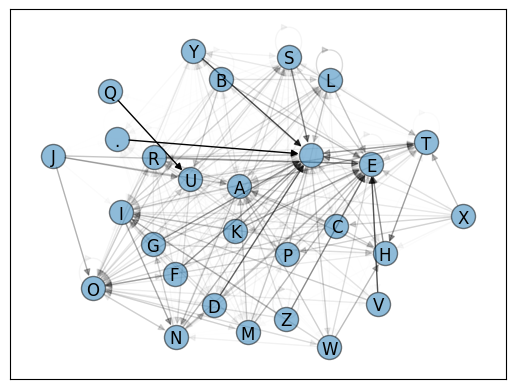

In [16]:
# Visualize the transition probabilities P
widths = nx.get_edge_attributes(G, 'weight')
nodelist = G.nodes()
#plt.figure(figsize=(12,8))

pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G,pos, nodelist=nodelist, node_size=300, edgecolors='black', alpha=.5)
nx.draw_networkx_edges(G,pos, edgelist = widths.keys(), alpha=array(list(widths.values())) )
_ = nx.draw_networkx_labels(G, pos=pos, verticalalignment='center_baseline',
        labels=dict(zip(nodelist,nodelist)) )

## Question: Compute the stationary distribution

We will use  matrix $P$ (computed above) to define the transition probability of a Markov Chain.
The state space of our Markov chain is the symbols in the variable `alphabet` (letters, space and a period).
Fix $\alpha \in (0, 1)$.
Given that the chain is at state $X_n = x$ at time $n$, we flip a coin that lands heads with probability $\alpha$ and tails with probability $1 - \alpha$.
If the coin lands heads, let $X_{n+1}$ be a symbol from the alphabet chosen randomly so that the probability of $X_{n+1} = y$ is $P(x, y)$.
If the coin lands tails, we choose $X_{n+1}$ from the alphabet, uniformly at random.
All coin tosses, and random draw of symbols are independent of all previous ones.
Let $\pi$ be the stationary distribution of this chain.

Implement the following function:

```python
def compute_π( G, P, α, ε ):
    """Compute the stationary distribution π with mean square error at most ε^2

    Returns a dictionary π where π[x] is the computed value of the stationary distribution
    """
```

1. The algorithm you use should be described and turned in with the written portion of the midterm.

2. One standard algorithm computes $\pi$ by computing the dominant eigenvector of the transition matrix.
   **DO NOT USE THIS ALGORITHM.** Find a Monte Carlo algorithm to compute $\pi$ using results we've done in class.

3. **DO NOT USE A STANDARD LIBRARY FUNCTION THAT COMPUTES $\pi$.**

4. The Monte Carlo algorithm you use will likely involve repeated random trials, or iteration.
   Thus, even though $\pi$ is not random, your computed $\pi$ will be random.
   Let $\hat \pi$ denote the random variable representing your (random) computed value of the stationary distribution.
   The precise meaning of *"mean square error at most $ε^2$"* is that
   $$
     \max_{x \in \mathcal X} \mathbb{E} |\hat \pi(x) - \pi(x)|^2 ≤ ε^2
   $$


   For full credit, you should choose the number of trials / iterations (in terms of ε) in order to ensure that the mean square error between the computed stationary distribution and the true stationary distribution is at most $ε^2$.
   
5. If you can not figure outhow to choose the number of trials / iterations in order to ensure that the mean square error is at most $ε^2$, then choose your number of trials / iterations to be a large enough value so that the results for the test cases below look reasonable. If the numerical results are good, you will get full credit on the coding portion; however only partial credit on the written portion describing the algorithm.

In [36]:
# prompt: full body of def compute_π:

import numpy as np
'''
def compute_π( G, P, α, ε ):
    """Compute the stationary distribution π with mean square error at most ε^2

    Returns a dictionary π where π[x] is the computed value of the stationary distribution
    """
    # Number of iterations for Monte Carlo simulation
    #num_iterations = int(1e6)  # You might need to adjust this based on ε and desired accuracy
    num_iterations = int(np.log(ε)/np.log(α))*2
    print(num_iterations)

    # Initialize the stationary distribution estimate
    π_hat = {x: 0 for x in G.nodes()}

    # Choose a random starting state
    current_state = np.random.choice(list(G.nodes()))
    π_hat[current_state] += 1

    for _ in range(num_iterations -1):
        # Flip a coin to determine the next state
        if np.random.rand() < α:
            # Choose next state based on transition probabilities
            next_state = np.random.choice(list(G.nodes()), p=[P[current_state][y] if y in P[current_state] else 0 for y in G.nodes()])
        else:
            # Choose next state uniformly at random
            next_state = np.random.choice(list(G.nodes()))

        current_state = next_state
        π_hat[current_state] += 1

    # Normalize the stationary distribution estimate
    total_counts = sum(π_hat.values())
    π_hat = {x: count / total_counts for x, count in π_hat.items()}

    return π_hat
'''
def compute_π( G, P, α, ε ):
    """Compute the stationary distribution π with mean square error at most ε^2

    Returns a dictionary π where π[x] is the computed value of the stationary distribution
    """
    # Number of iterations for Monte Carlo simulation
    #num_iterations = int(1e6)  # You might need to adjust this based on ε and desired accuracy
    num_iterations = int(np.log(ε)/np.log(α))*2
    print(num_iterations)

    # Initialize the stationary distribution estimate
    π_hat_now = {x: 2000 for x in list(G.nodes())}

    for _ in range(num_iterations -1):
        # Flip a coin to determine the next state
        π_hat_new = {x: 0 for x in G.nodes()}
        for k,v in π_hat_now.items():
            if v==0:
                continue
            rand_vals=np.random.rand(v)
            trans_count=np.sum(rand_vals<α)
            rand_count=v-trans_count

            next_state_trans = np.random.choice(list(G.nodes()), size=trans_count,p=[P[k][y] if y in P[k] else 0 for y in G.nodes()])
            next_state_rand = np.random.choice(list(G.nodes()),size=rand_count)

            unique_elements, counts = np.unique(np.concatenate((next_state_trans,next_state_rand)), return_counts=True)
            ele_count_dict = dict(zip(unique_elements, counts))
            for k_,v_ in ele_count_dict.items():
                π_hat_new[k_]+=v_


        π_hat_now = π_hat_new
    # Normalize the stationary distribution estimate
    total_counts = sum(π_hat_now.values())
    π_hat = {x: count / total_counts for x, count in π_hat_now.items()}

    return π_hat


12
24
112


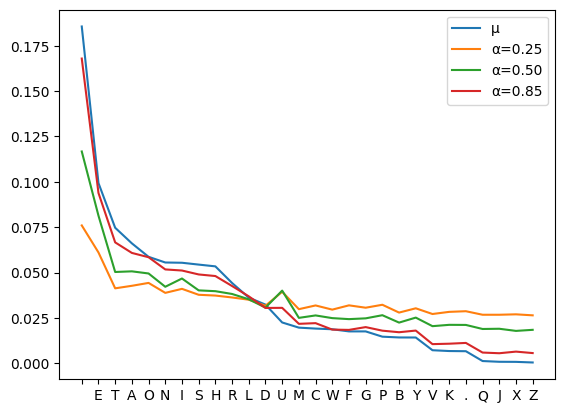

In [37]:
# If you want to test you got things correct, here are a few plots of π as α varies
keys = sorted( μ, key = lambda k: μ[k], reverse=True )
def plot_dist( μ, keys, **kwargs ):
    plot( keys, [μ[k] for k in keys], **kwargs )

plot_dist( μ, keys, label='μ' )
for α in [ .25, .5, .85]:
    π = compute_π( G, P, α, .01 )
    plot_dist( π, keys, label=f'α={α:.2f}' )

legend()